In [29]:
import scipy.stats as stats
import numpy as np
import math
from scipy.stats import norm
from scipy.stats import gamma

n=50

true_beta = np.transpose(stats.norm.rvs(loc=0,scale=1,size=2))
true_phi = stats.gamma.rvs(a=3,scale=1/2,size=1)

x = np.transpose(np.array([np.ones(n),stats.norm.rvs(loc=0,scale=1,size=n)]))
y = np.random.normal(x.dot(true_beta), np.sqrt(1/true_phi))


beta0 = stats.norm.rvs(loc=0,scale=1,size=2)
phi0 = stats.gamma.rvs(a=3,scale=1/2,size=1)
theta0 = np.hstack([beta0, phi0])

#Set hyperparameters
a = 3.0
b= 2.0


print(true_beta,true_phi)
print(theta0)

[-1.32609994 -0.16096869] [ 0.10977059]
[ 0.47671837  0.13782347  2.34496936]


In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
def leapfrog(y,x,theta, r, eps):
    n = y.shape[0]
    gradients = np.hstack([theta[2]*(np.transpose(y).dot(x)-np.transpose(x).dot(x).dot(theta[0:2]))-.01*theta[0:2],(.5*n+a-1)/theta[2]-b-0.5*np.transpose((y-x.dot(theta[0:2]))).dot(y-x.dot(theta[0:2]))])
    r_upd = r + eps/2 * (gradients)
    theta_upd = theta + eps * r_upd
    gradients = np.hstack([theta_upd[2]*(np.transpose(y).dot(x)-np.transpose(x).dot(x).dot(theta_upd[0:2]))-.01*theta_upd[0:2],(.5*n+a-1)/theta[2]-b-0.5*np.transpose((y-x.dot(theta_upd[0:2]))).dot(y-x.dot(theta_upd[0:2]))])
    r_upd = r_upd + eps/2 * (gradients)
    return theta_upd, r_upd

In [32]:
def log_joint(y, x, theta): 
    n = y.shape[0]
    return sum(norm.logpdf(y,loc=x.dot(theta[0:2]), scale=1/np.sqrt(theta[2])))+norm.logpdf(theta[0],loc=0,scale=1/np.sqrt(.01))+norm.logpdf(theta[1],loc=0,scale=1/np.sqrt(.01)) +gamma.logpdf(theta[2], a, scale=1/b) 

In [33]:
def BuildTree(y,x,theta, r, u, v, j, eps):
    triangle_max = 1000 #recommend value pg 1359
    if(j==0):
        #base case, take one leapfrog step in direction v
        theta_prime,r_prime = leapfrog(y,x,theta,r,v*eps)
        if(u <= np.exp(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime))):
            n_prime = 1
        else:
            n_prime = 0
        if(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime) > u-triangle_max):
            s_prime = 1
        else:
            s_prime = 0
        return theta_prime,r_prime,theta_prime,r_prime,theta_prime,n_prime,s_prime    
    else:
        #recursion-build the left and right subtrees
        theta_minus,r_minus,theta_plus,r_plus,theta_prime,n_prime,s_prime = BuildTree(y,x,theta,r,u,v,j-1,eps)
        if(s_prime==1):
            if(v == -1):
                theta_minus,r_minus,dash1,dash2,theta_primep,n_primep,s_primep = BuildTree(y,x,theta_minus,r_minus,u,v,j-1,eps)
            else:
                dash1,dash2,theta_plus,r_plus,theta_primep,n_primep,s_primep = BuildTree(y,x,theta_plus,r_plus,u,v,j-1,eps)
            #if(n_prime+n_primep==0):
                #print('Ahhhh cant divide by zero:',n_prime,n_primep)
                #p=0.99
            #else:    
            p = np.exp(np.log(n_primep)-np.log(n_prime+n_primep))
            unif = np.random.uniform()
            if(p>u):
                theta_prime = theta_primep
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):  
                s_prime = s_primep  
            else:
                s_prime = 0  
            n_prime = n_prime+n_primep
    return theta_minus,r_minus,theta_plus,r_plus,theta_prime,n_prime,s_prime

In [34]:
def hamilt_mc(theta0, y,x, eps, M):
    theta_m = np.zeros((M,3))
    theta_m[0,:] = theta0
    for m in range(1,M):
        #print('M: ',m,' Theta: ',theta_m[m-1,:])
        r0 = stats.norm.rvs(size=3)
        u = np.random.uniform(low=0,high=np.exp(log_joint(y,x,theta_m[m-1,:])-(1/2)*r0.dot(r0)))
        theta_minus = theta_m[m-1,:]
        theta_plus = theta_m[m-1,:]
        r_minus = r0
        r_plus = r0
        j=0
        theta_m[m,:] = theta_m[m-1,:]
        n = 1
        s=1
        while(s==1):
            v_j = np.random.choice([-1,1])
            if(v_j==-1):
                theta_minus,r_minus,dash1,dash2,theta_prime,n_prime,s_prime = BuildTree(y,x,theta_minus,r_minus,u,v_j,j,eps)
            else:
                dash1,dash2,theta_plus,r_plus,theta_prime,n_prime,s_prime = BuildTree(y,x,theta_plus,r_plus,u,v_j,j,eps)
            if(s_prime == 1):
                p = min(1,n_prime/n)
                unif = np.random.uniform()
                if(p>u):
                    theta_m[m,:] = theta_prime
            n = n+n_prime
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):
                s = s_prime
            else:
                s = 0
            j = j+1    
    return(theta_m)

In [37]:
M = 1000
eps = .005

In [38]:
%%time
results = hamilt_mc(theta0, y,x, eps, M)
print("truth", (true_beta, true_phi))
beta0_found = np.mean(results[round(4*M/5):(M-1),0])
beta1_found = np.mean(results[round(4*M/5):(M-1),1])
phi_found = np.mean(results[round(4*M/5):(M-1),2])
print("Mean after burn in we find",beta0_found,beta1_found ,phi_found)


truth (array([-1.32609994, -0.16096869]), array([ 0.10977059]))
Mean after burn in we find -1.29350987358 -0.167612856598 0.0867621317203
CPU times: user 51.1 s, sys: 403 ms, total: 51.5 s
Wall time: 51.5 s


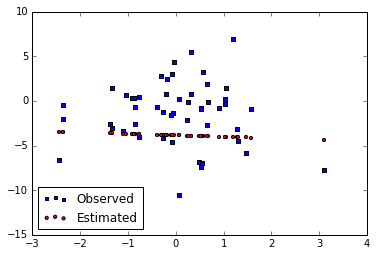

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
betas_found = np.hstack([beta0_found,beta1_found])
y_sim = stats.norm.rvs(loc=x.dot(betas_found),scale=1/np.sqrt(phi_found))
#y_sim = stats.norm.rvs(loc=x*beta_found,scale=phi_found)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x[:,1], y, s=10, c='b', marker="s", label='Observed')
ax1.scatter(x[:,1], y_sim, s=10, c='r', marker="o", label='Estimated')
plt.legend(loc='lower left');
plt.show()
